In [1]:
# вернемся к части 3 и скопируем оттуда стартовый код

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# построим словарь отображения из букв в индексы
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# и наоборот
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
# построим датасет
block_size = 3  # длина контекста: сколько букв учитывать при предсказании следующей буквы

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # обрезаем и добавляем
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [25]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # дополнительный флаг, который говорит нам, находимся ли мы сейчас в режиме обучения
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)  # среднее по батчу во время обучения
            xvar = x.var(0, keepdim=True, unbiased=True)  # дисперсия по батчу во время обучения
        else:
            xmean = self.running_mean  # среднее, которое используем на инференсе
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # нормализуем вход
        self.out = self.gamma * xhat + self.beta
        # обновим буфферы
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [26]:
torch.manual_seed(42)

In [27]:
n_embd = 10  # размер эмбеддинга
n_hidden = 200  # число нейронов в скрытом слое сети

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    emb = C[Xb]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


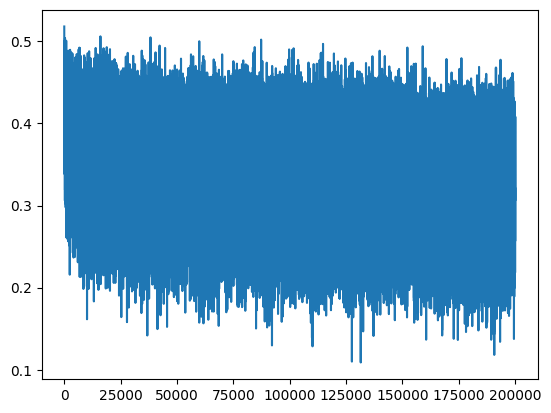

In [29]:
plt.plot(lossi);

In [30]:
# переведем слои с режим eval, особенно необходимо для batchnorm
for layer in layers:
    layer.training = False

In [31]:
# замерим лосс
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]  # получаем эмбеддинги букв
    x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)  # считаем лосс
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583252906799316
val 2.1065292358398438


In [33]:
for _ in range(20):

    out = []
    context = [0] * block_size  # сначала у нас только фиктивные буквы "..."
    while True:
        emb = C[torch.tensor([context])]  # [1, block_size, embd]
        x = emb.view(emb.shape[0], -1)  # соединяем векторы букв
        for layer in layers:
            x = layer(x)
            
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


# Начнем исправлять модель

## для начала поправим график лосса, он толстый

In [35]:
lossi[:10]

[0.5180676579475403,
 0.5164594054222107,
 0.507362961769104,
 0.507546603679657,
 0.4992470443248749,
 0.5014019012451172,
 0.5049523115158081,
 0.48866209387779236,
 0.4999050199985504,
 0.4899313449859619]

In [37]:
torch.arange(10).view(2, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

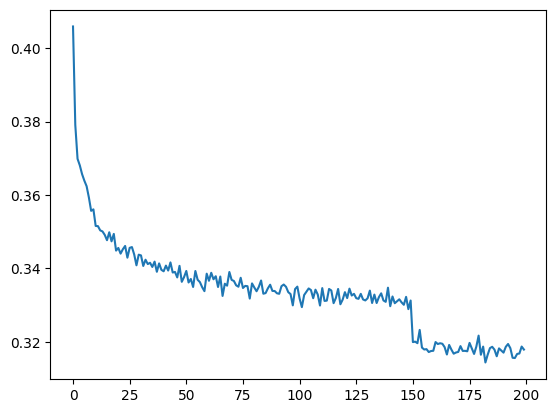

In [40]:
# берем 200000 итераций и нарезаем их по 1000, усредняем, на это графике видно, где мы уменьшили learning rate:)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

## поправим слои

In [41]:
# мы создали список слоев, но почему-то C и операция по конкатенации не входит в этот список

In [42]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [43]:
n_embd = 10  # размер эмбеддинга
n_hidden = 200  # число нейронов в скрытом слое сети

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
]

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    x = Xb 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3055


In [45]:
# напишем свой Sequential, чтобы вызывать всю сеть как один слой без лишних циклов

In [46]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [53]:
n_embd = 10  # размер эмбеддинга
n_hidden = 200  # число нейронов в скрытом слое сети

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
])

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [54]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.4268
  10000/ 200000: 2.6704
  20000/ 200000: 2.1433
  30000/ 200000: 2.2168
  40000/ 200000: 2.0847
  50000/ 200000: 2.1472
  60000/ 200000: 2.1448
  70000/ 200000: 2.4502
  80000/ 200000: 2.0554
  90000/ 200000: 2.0288
 100000/ 200000: 1.8362
 110000/ 200000: 2.4535
 120000/ 200000: 2.5425
 130000/ 200000: 2.0663
 140000/ 200000: 2.2757
 150000/ 200000: 2.2964
 160000/ 200000: 2.2345
 170000/ 200000: 1.9848
 180000/ 200000: 2.0163
 190000/ 200000: 2.3230


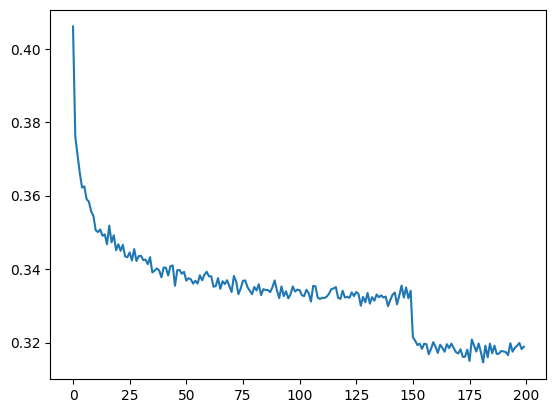

In [55]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [56]:
# все упрощается

In [57]:
# переведем слои с режим eval, особенно необходимо для batchnorm
for layer in model.layers:
    layer.training = False

In [58]:
# замерим лосс
@torch.no_grad()  # декоратор отключает отслеживание градиентов
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)  # считаем лосс
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0593767166137695
val 2.1061389446258545


In [59]:
for _ in range(20):

    out = []
    context = [0] * block_size  # сначала у нас только фиктивные буквы "..."
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

nee.
damayana.
radhy.
sir.
clea.
amonzliny.
robeysia.
kasia.
sorelyn.
haeledicaedricky.
nay.
amaycee.
pesco.
jayoud.
niyashmurionatheer.
ryn.
sebal.
jourittessydie.
nakha.
zakley.


# Строим WaveNet

In [60]:
# пытаемся не пихать сразу все буквы в первый слой и потом строить из этого сеть

In [61]:
# теперь возьмем 8 букв, а не 3, перестроим датасет
# но все 8 букв мы не хотим сразу конкатенировать и пихать в первый слой, надо изменить подход

In [62]:
# построим датасет
block_size = 8  # длина контекста: сколько букв учитывать при предсказании следующей буквы

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # обрезаем и добавляем
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [63]:
# но перед тем как мы попробуем менять архитектуру, что если мы просто возбмем и обучим текущую, будет ли лучше?

In [64]:
n_embd = 10  # размер эмбеддинга
n_hidden = 200  # число нейронов в скрытом слое сети

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
])

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [65]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3796
  10000/ 200000: 2.2009
  20000/ 200000: 2.0528
  30000/ 200000: 2.0324
  40000/ 200000: 1.8629
  50000/ 200000: 1.9926
  60000/ 200000: 2.3152
  70000/ 200000: 1.9843
  80000/ 200000: 1.5300
  90000/ 200000: 2.0214
 100000/ 200000: 2.1819
 110000/ 200000: 1.7210
 120000/ 200000: 1.5531
 130000/ 200000: 1.7101
 140000/ 200000: 2.2392
 150000/ 200000: 2.0091
 160000/ 200000: 2.0276
 170000/ 200000: 1.5637
 180000/ 200000: 2.0677
 190000/ 200000: 1.9927


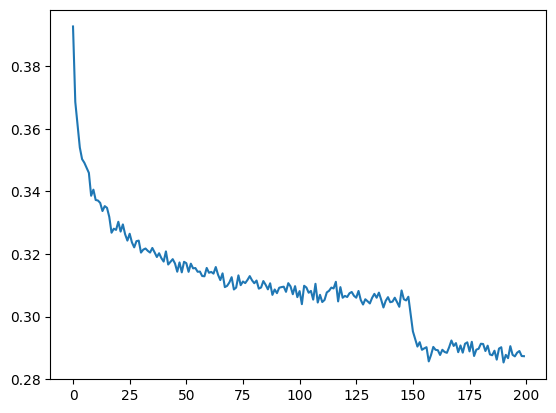

In [66]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [67]:
for layer in model.layers:
    layer.training = False

In [68]:
split_loss('train')
split_loss('val')

train 1.9162566661834717
val 2.0248525142669678


In [69]:
for _ in range(20):

    out = []
    context = [0] * block_size  # сначала у нас только фиктивные буквы "..."
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

navaya.
joylani.
arenn.
zayda.
isley.
jona.
lei.
lygdon.
matoi.
pheozianne.
zyon.
atrimi.
mari.
gwen.
muhamii.
zystee.
lionni.
anai.
dawsyn.
zelih.


In [70]:
# стало немного лучше, будем отталкиваться от этого качества

## проанализируем прямой проход

In [71]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # посмотрим на батч из 4
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 10,  1, 14,  5],
        [ 0,  7,  5, 14, 20, 18,  5,  5],
        [ 0,  0,  0,  8,  1, 18, 20,  1],
        [ 0,  0,  0,  0,  0,  0, 19,  8]])

In [73]:
# берем вход из 4 примеров длины 8
# слой эмбеддинга выдает для каждого числа из 8 для каждого примера вектор длины 10
# потом 8 эмбеддингов конкатенируются один за другим в последовательность длины 80
# и линейный слой превращает это все в 200
model.layers[0].out.shape, model.layers[1].out.shape, model.layers[2].out.shape

(torch.Size([4, 8, 10]), torch.Size([4, 80]), torch.Size([4, 200]))

In [74]:
# в линейном слое происходит примерно так
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [76]:
# но линейный слой мощнее, чем кажется, он работает не только с 2D входами
(torch.randn(4, 5, 10, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
# магия в том, что линейный слой работает только с последней размерностью, остальные остаются неизменными
# слой воспринимает все остальные размерности как просто размерность батча

torch.Size([4, 5, 10, 200])

In [77]:
xx = torch.randn(4, 5, 10, 80)
ww = torch.randn(80, 200)
bb = torch.randn(200)
oo = xx @ ww + bb

In [82]:
oo[0, 0].shape, xx[0, 0].shape

(torch.Size([10, 200]), torch.Size([10, 80]))

In [87]:
torch.all(xx[0, 0] @ ww + bb == oo[0, 0])
# считается параллельно

tensor(True)

In [88]:
# это очень удобно, ведь мы не хотим загружать в сеть длинную склеенную последовательность
# 1 2 3 4 5 6 7 8
# теперь мы можем ввести новую размерность и подавать так
# (1 2) (3 4) (5 6) (7 8)
# и обработать параллельно эти группы

In [89]:
# теперь линейный вход принимает по 2 буквы (10 - размер эмбеддинга), но 4 группами
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [90]:
# надо поменять линейный слой и Flatten слой

In [91]:
list(range(10))[::2], list(range(10))[1::2]

([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])

In [92]:
e = torch.randn(4, 8, 10)  # хотим [4, 4, 20]
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

torch.Size([4, 4, 20])

In [95]:
(torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2) == e.view(4, 4, 20)).all()

tensor(True)

In [96]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

In [101]:
# проанализируем, что слой работает также как раньше при таких условиях

In [98]:
n_embd = 10  # размер эмбеддинга
n_hidden = 200  # число нейронов в скрытом слое сети

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
])

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [99]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # посмотрим на батч из 4
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  2],
        [14, 19, 20,  1, 14, 20,  9, 14],
        [ 0,  0,  0,  0,  1, 14, 19,  8],
        [ 0,  0,  0,  0,  1, 14,  9, 12]])

In [100]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [102]:
# поменяем теперь на нашу идею

In [106]:
n_embd = 10  # размер эмбеддинга
n_hidden = 68  # число нейронов в скрытом слое сети

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
])

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [107]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # посмотрим на батч из 4
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0, 22,  9,  1],
        [ 0,  0,  0,  0, 11, 14, 15, 24],
        [ 0,  0,  1,  1, 18, 25,  1,  8]])

In [108]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [109]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3952
  10000/ 200000: 2.0366
  20000/ 200000: 2.2920
  30000/ 200000: 2.2559
  40000/ 200000: 2.2216
  50000/ 200000: 1.9411
  60000/ 200000: 2.0966
  70000/ 200000: 2.0113
  80000/ 200000: 2.3477
  90000/ 200000: 1.9293
 100000/ 200000: 2.1300
 110000/ 200000: 2.0340
 120000/ 200000: 2.0336
 130000/ 200000: 2.4064
 140000/ 200000: 2.2896
 150000/ 200000: 1.8975
 160000/ 200000: 1.8809
 170000/ 200000: 1.9548
 180000/ 200000: 1.7827
 190000/ 200000: 1.8959


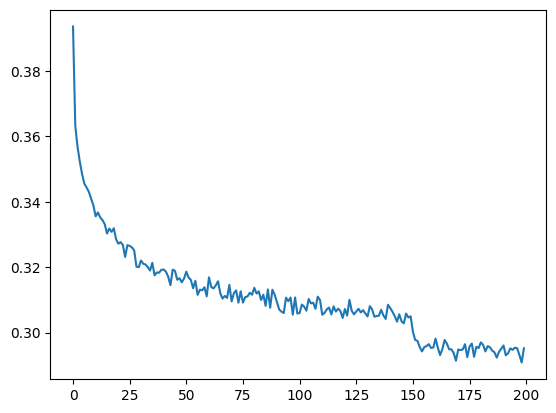

In [110]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [111]:
for layer in model.layers:
    layer.training = False

In [112]:
split_loss('train')
split_loss('val')

train 1.9409512281417847
val 2.0314455032348633


In [113]:
for _ in range(20):

    out = []
    context = [0] * block_size  # сначала у нас только фиктивные буквы "..."
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

trivion.
jayton.
malvy.
hanne.
syla.
derion.
zyresie.
daliia.
arelzie.
catisa.
emmari.
slayar.
guhfiahair.
joeeslee.
mardowie.
evonesia.
callys.
kameiah.
jaylin.
saylah.


## batchnorm bug

In [115]:
# у нас есть баг в батчнорме
# сейчас он ожидает, что вход будет двумерным и мы берем статистики по 0 оси
# и все не ломается благодаря broadcasting в pytorch

In [116]:
# что происходит внутри?
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)  # 1, 4, 68
evar = e.var(0, keepdim=True)  # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [119]:
model.layers[3].running_mean.shape  # мы ожидаем 68 в качестве длины
# получается батчнорм сейчас работает параллельно для 4
# на самом деле мы хотим, чтобы и 32 и 4 были для нас батчевыми размерностями

torch.Size([1, 4, 68])

In [120]:
# что происходит внутри?
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True)  # 1, 1, 68
evar = e.var((0, 1), keepdim=True)  # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [121]:
emean.shape

torch.Size([1, 1, 68])

In [122]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  # дополнительный флаг, который говорит нам, находимся ли мы сейчас в режиме обучения
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
                
            xmean = x.mean(dim, keepdim=True)  # среднее по батчу во время обучения
            xvar = x.var(dim, keepdim=True, unbiased=True)  # дисперсия по батчу во время обучения
        else:
            xmean = self.running_mean  # среднее, которое используем на инференсе
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # нормализуем вход
        self.out = self.gamma * xhat + self.beta
        # обновим буфферы
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

## переобучим

In [123]:
n_embd = 10  # размер эмбеддинга
n_hidden = 68  # число нейронов в скрытом слое сети

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
])

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [124]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # посмотрим на батч из 4
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  2, 18,  9, 20, 20,  1],
        [ 0,  3,  8,  1, 19,  9, 20, 25],
        [ 0,  0,  0,  0,  0,  4, 15, 19]])

In [125]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [126]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [127]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3245
  10000/ 200000: 2.0789
  20000/ 200000: 1.7799
  30000/ 200000: 2.2346
  40000/ 200000: 2.0894
  50000/ 200000: 1.8455
  60000/ 200000: 2.1566
  70000/ 200000: 2.1311
  80000/ 200000: 1.8887
  90000/ 200000: 2.1950
 100000/ 200000: 1.7845
 110000/ 200000: 1.7650
 120000/ 200000: 1.9728
 130000/ 200000: 1.6999
 140000/ 200000: 1.9007
 150000/ 200000: 1.8938
 160000/ 200000: 1.8640
 170000/ 200000: 1.8100
 180000/ 200000: 1.6752
 190000/ 200000: 1.9155


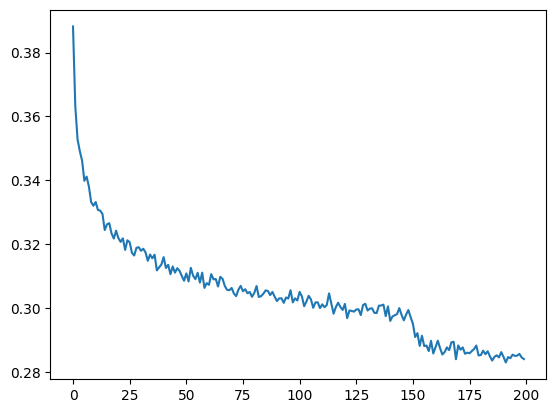

In [128]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [129]:
for layer in model.layers:
    layer.training = False

In [130]:
split_loss('train')
split_loss('val')
# исправление бага немного улучшило картину

train 1.9146116971969604
val 2.0153582096099854


## добавим модели параметров

In [133]:
n_embd = 24  # размер эмбеддинга
n_hidden = 128  # число нейронов в скрытом слое сети

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size) 
])

with torch.no_grad():
    # сделать менее уверенным softmax
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [134]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]  # батчи

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # считаем лосс

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.5204
  10000/ 200000: 2.2145
  20000/ 200000: 2.0569
  30000/ 200000: 1.9700
  40000/ 200000: 2.2990
  50000/ 200000: 1.7731
  60000/ 200000: 1.9625
  70000/ 200000: 1.6672
  80000/ 200000: 2.1167
  90000/ 200000: 1.9601
 100000/ 200000: 2.1853
 110000/ 200000: 2.0207
 120000/ 200000: 1.7150
 130000/ 200000: 1.9536
 140000/ 200000: 1.6416
 150000/ 200000: 2.2536
 160000/ 200000: 1.7138
 170000/ 200000: 1.5363
 180000/ 200000: 1.5227
 190000/ 200000: 1.4754


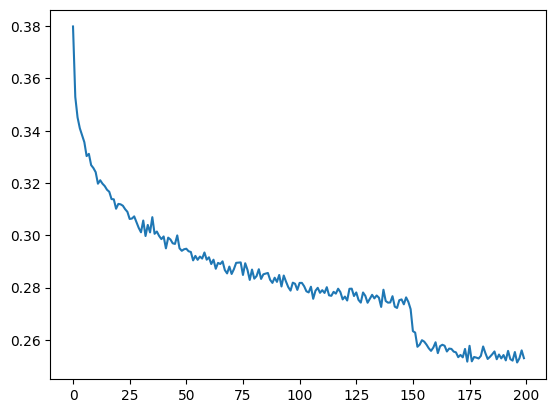

In [135]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [136]:
for layer in model.layers:
    layer.training = False

In [137]:
split_loss('train')
split_loss('val')
# получили еще улучшение

train 1.768920660018921
val 1.986614465713501


## Свертки?

In [138]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [139]:
# прямой проход по 1 примеру
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [140]:
# прямой проход по всем
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [141]:
# со свертками нам не нужно таким способом формировать данные
# свертка по сути это цикл